In [58]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy import stats
from sklearn import metrics
%matplotlib inline

In [2]:
X = []
y = []
trdata = pd.read_csv('mnist_train.csv', sep=',', engine='python')
tstdata = pd.read_csv('mnist_test.csv', sep=',', engine='python')

X = trdata.as_matrix()
X = X.astype(np.float)
y = X[:,0]
X = X[:,1:]
print(X.shape, y.shape)

Xt = tstdata.as_matrix()
Xt = Xt.astype(np.float)
yt = Xt[:,0]
Xt = Xt[:,1:]
print(Xt.shape, yt.shape)

(59999, 784) (59999,)
(9999, 784) (9999,)


In [3]:
rownorms = np.linalg.norm(X,axis=1)
X = X / rownorms[:, np.newaxis]

rownorms = np.linalg.norm(Xt,axis=1)
Xt = Xt / rownorms[:, np.newaxis]

In [139]:
# Creds to Conner's implementation for inspiration of general EM function
def EM(X, theta, k, M_step_func, iters, likelihood_func, objective_func):
    r_ik = 1. / k * np.ones((X.shape[0], k)) # uniform initial responsibility
    
    pi = 1. / k * np.ones(k)
    
    objectives = [objective_func(X ,r_ik , pi, theta)]
    
    for i in range(iters):
        # E-step, find r_ik from previous theta and pi      
        r_ik_numer = likelihood_func(X, theta) * pi
        
        # not sure if denominator is right, because should be sum over k'
        # still good approximation because will be relatively small?
        r_ik_denom = r_ik.sum(axis = 1)
        r_ik_denom = r_ik_denom.reshape(r_ik_denom.shape[0], 1)
        
        r_ik = r_ik_numer / r_ik_denom
        r_ik /= r_ik.sum(axis = 1)[:, np.newaxis]
        
        # M-step
        pi, theta = M_step_func(X, r_ik)
        objectives.append(objective_func(X ,r_ik , pi, theta))
        
    return objectives, r_ik, pi, theta

In [142]:
def bernoulli_mm(X, k, dir_alphas, alpha, beta, iters):
    log_beta_pdf = lambda mean : np.log(stats.beta.pdf(mean, alpha, beta))
    log_dirich_pdf = lambda pi: np.log(stats.dirichlet.pdf(pi, dir_alphas))

    # pooled variance initial S_)
    S_0 = np.diag(np.var(X, axis = 0)) * k**(1 / X.shape[1])
    
    # initially get random vects from X as means
    mean = X[np.random.randint(0, X.shape[0], (k,))]
   
    
    # initial theta
    theta = mean
    
    def bern_likelihood(X, theta):
        p = np.zeros((X.shape[0], k))       
        for i in range(X.shape[0]):
            mu = theta.copy()
            mu.T[X[i] == 0] = 1 - mu.T[X[i] == 0]
            mu = np.log(mu)
            mu = mu.sum(axis = 1)
            # This one weird numerical trick will help you lose NaNs
            # Floats hate him
            mu[mu<1e-100] = 1e-100
            p[i] = mu
        return p
    
    def M_step(X, r):
        r_k = r.sum(axis = 0)
        pi = (r_k + dir_alphas - 1) / (X.shape[0] + dir_alphas.sum() - k)
        
        # creds to Conner for following line. Way cleaner than my loops and works
        theta = ((X[:,:,np.newaxis] * r[:,np.newaxis,:]).sum(axis=0) / (r_k + alpha + beta - 2)).T
  
        return pi, theta
    
    def objective(X, r, pi, theta):
        '''
        More props to Conner.
        '''        
        log_prior = log_beta_pdf(theta).sum() + log_dirich_pdf(pi)
        
        pi_term = (r * np.log(pi)[np.newaxis,:]).sum()
        
        likelihood_term = r * np.log(bern_likelihood(X, theta))
        
        likelihood_term = likelihood_term[r > 1e-12].sum()
        
        return likelihood_term + pi_term + log_prior
    
    return EM(X, theta, k, M_step, iters, bern_likelihood, objective)

In [145]:
N = int(1000)
subset_ix = np.random.randint(0,X.shape[0],(N,))
X1 = X[subset_ix]
obj, r, pi, theta = bernoulli_mm(X1, k=10, dir_alphas=np.ones(10), alpha=1,beta=1,iters=10)

[-232548.29256491864, -232548.29256491855, -232548.29256491855, -232548.29256491855, -232548.29256491855, -232548.29256491855, -232548.29256491855, -232548.29256491855, -232548.29256491855, -232548.29256491855, -232548.29256491855]


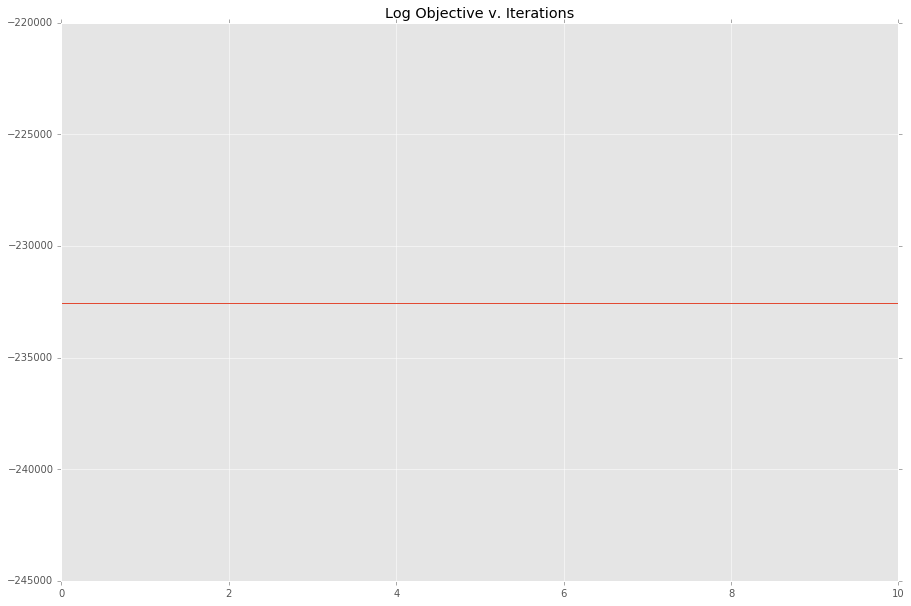

In [147]:
plt.figure(figsize = (15,10))
plt.plot(obj)
plt.title("Log Objective v. Iterations")
print(obj)

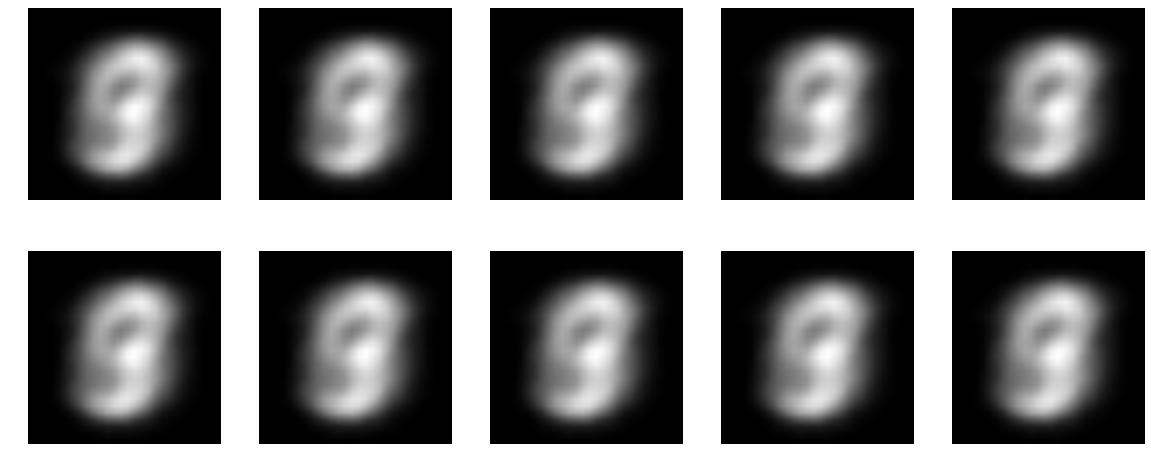

In [148]:
plt.figure(figsize=(20, 8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(theta[i].reshape((28,28)), cmap = "gray")
    plt.axis('off')